In [1]:
import theano
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import numpy as np
import sys
import os
sys.path.append("../lib")
from load import getValData
from load import faces
import pickle
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d
from six.moves import cPickle


Using gpu device 0: GeForce GTX 980


In [2]:
ValX , ValY = getValData(onehot=True)

ValX = ValX.reshape(-1, 1, 48, 48)

trX, teX, trY, teY = faces(onehot=True)

trX = trX.reshape(-1, 1, 48, 48)
teX = teX.reshape(-1, 1, 48, 48)

In [3]:
srng = RandomStreams()

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape):
    W = theano.shared(floatX(np.random.randn(*shape) * 0.01))
    return W

def init_bias(shape):
    b_values = np.zeros((shape[0],), dtype=theano.config.floatX)
    b = theano.shared(value=b_values, borrow=True )
    return b

def rectify(X):
    return T.maximum(X, 0.)

def softmax(X):
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x'))
    return e_x / e_x.sum(axis=1).dimshuffle(0, 'x')

def dropout(X, p=0.):
    if p > 0:
        retain_prob = 1 - p
        X = X *  srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X = (X/retain_prob)
    return X

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

def negative_log_likelihood(p_y_given_x,y):
        """Return the mean of the negative log-likelihood of the prediction
        of this model under a given target distribution.

        .. math::

            \frac{1}{|\mathcal{D}|} \mathcal{L} (\theta=\{W,b\}, \mathcal{D}) =
            \frac{1}{|\mathcal{D}|} \sum_{i=0}^{|\mathcal{D}|}
                \log(P(Y=y^{(i)}|x^{(i)}, W,b)) \\
            \ell (\theta=\{W,b\}, \mathcal{D})

        :type y: theano.tensor.TensorType
        :param y: corresponds to a vector that gives for each example the
                  correct label

        Note: we use the mean instead of the sum so that
              the learning rate is less dependent on the batch size
        """
        # start-snippet-2
        # y.shape[0] is (symbolically) the number of rows in y, i.e.,
        # number of examples (call it n) in the minibatch
        # T.arange(y.shape[0]) is a symbolic vector which will contain
        # [0,1,2,... n-1] T.log(self.p_y_given_x) is a matrix of
        # Log-Probabilities (call it LP) with one row per example and
        # one column per class LP[T.arange(y.shape[0]),y] is a vector
        # v containing [LP[0,y[0]], LP[1,y[1]], LP[2,y[2]], ...,
        # LP[n-1,y[n-1]]] and T.mean(LP[T.arange(y.shape[0]),y]) is
        # the mean (across minibatch examples) of the elements in v,
        # i.e., the mean log-likelihood across the minibatch.
        return -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])


In [4]:
def model(X, w, b , w2, b2 ,  w3, b3, w4, b4, w5 , b5, w6 , b6 , w_o, b_o, p_drop_conv, p_drop_hidden):
    l1a = conv2d(X, w)
    l1a = rectify(l1a + b.dimshuffle('x', 0, 'x', 'x'))
    l1 = max_pool_2d(l1a, (2, 2))
    l1 = dropout(l1, p_drop_conv)

    l2a = conv2d(l1, w2)
    l2a = rectify(l2a + b2.dimshuffle('x', 0, 'x', 'x'))
    #l2 = max_pool_2d(l2a, (2, 2))
    l2 = dropout(l2a, p_drop_conv)
    
    l3a = conv2d(l2, w3)
    l3a = rectify(l3a + b3.dimshuffle('x', 0, 'x', 'x'))
    l3 = max_pool_2d(l3a, (2, 2))
    l3 = dropout(l3, p_drop_conv)

    l4a = conv2d(l3, w4)
    l4b = rectify(l4a + b4.dimshuffle('x', 0, 'x', 'x'))
    l4 = T.flatten(l4b, outdim=2)
    l4 = dropout(l4, p_drop_conv)

    l5 = rectify(T.dot(l4, w5) + b5.dimshuffle('x', 0 ))
    l5 = dropout(l5, p_drop_hidden)
    
    l6 = rectify(T.dot(l5, w6) + b6.dimshuffle('x', 0))
    l6 = dropout(l6, p_drop_hidden)

    pyx = T.nnet.softmax(T.dot(l6, w_o) + b_o.dimshuffle('x', 0))
    return l1, l2, l3, l4, l5, l6, pyx

In [5]:
#Predict Loop
modelParams = open("Models/ModelSnapshot128.pkl")
Params = cPickle.load(modelParams)


In [6]:
X = T.ftensor4()
l1, l2, l3, l4, l5,l6, py_x = model(X, Params[0], Params[1], Params[2], Params[3], Params[4], Params[5], Params[6], Params[7], Params[8], Params[9], Params[10], Params[11], Params[12], Params[13], 0., 0.)
y_x = T.argmax(py_x, axis=1)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

In [7]:
errorVal = np.mean(np.argmax(ValY, axis=1) == predict(ValX))
error = np.mean(np.argmax(teY, axis=1) == predict(teX))

In [8]:
print "Validation error %f and test error %f " %(errorVal,error)

Validation error 0.427477 and test error 0.623293 


In [15]:
predicted = predict(teX)
confusion = (np.argmax(ValY, axis=1) == predict(ValX))
real = np.argmax(teY, axis=1)
confusion = np.zeros((7,7))
for i in range(0 , len(real)):
    j = real[i]
    k = predicted[i]
    #print "Real:  %d , predicted %d"%(j,k)
    confusion[j][k] = confusion[j][k] + 1
print confusion

[[ 266.    4.   32.   29.   66.   15.   55.]
 [  14.   32.    2.    3.    3.    0.    2.]
 [  56.    3.  199.   33.   91.   39.   75.]
 [  31.    1.   20.  736.   26.   15.   66.]
 [  78.    2.   71.   57.  315.   14.  116.]
 [  15.    0.   24.   20.   13.  325.   18.]
 [  57.    3.   28.   57.   92.    6.  364.]]


0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [14]:
print "Precision: "
for j in range(0,7):
    print (confusion[j][j]/sum(confusion[j][:]))

print "true negatives : "
for j in range(0,7):
    print (sum(confusion[j][:]) - confusion[j][j])/sum(confusion[j][:])

Precision: 
0.569593147752
0.571428571429
0.401209677419
0.822346368715
0.482388973966
0.78313253012
0.599670510708
true negatives : 
0.430406852248
0.428571428571
0.598790322581
0.177653631285
0.517611026034
0.21686746988
0.400329489292


In [22]:
lists = []
infile = open('ErrosCNN7Layes.pickle', 'r')
while 1:
    try:
        lists.append(pickle.load(infile))
    except (EOFError):
        break
infile.close()

In [82]:
print cost

[ 1.81201673  1.78938532  1.78786612  1.68980694  1.70473719  1.6123538
  1.58092082  1.58917487  1.56166708  1.52225387  1.50124145  1.50133729
  1.48043382  1.50203335  1.49468005  1.42496502  1.43840277  1.43102515
  1.40043116  1.39737022  1.39590347  1.36640322  1.32965434  1.35040903
  1.37817538  1.31465662  1.35909534  1.28199673  1.22786248  1.24787796
  1.30248415  1.2352556   1.25586164  1.17010212  1.24778032  1.10011244
  1.1055454   1.19666934  1.22666359  1.10712314  1.09863293  1.11927903
  1.08927691  1.0394994   1.05245209  1.1366719   1.01238561  1.04693818
  1.08347821  1.00353467  1.0902034   0.99611217  0.97325486  0.97332823
  0.90335679  0.99484444  1.03279829  0.96510619  0.98710448  0.97682065
  0.93315232  0.93615872  0.91765058  0.95142263  0.91381621  0.86871129
  0.90077484  0.86697125  0.79280376  0.80114472  0.82677597  0.88689357
  0.79367012  0.72626221  0.70978898  0.68396556  0.84545875  0.66677564
  0.77381599  0.69921428  0.70209724  0.69078064  0.

In [92]:
print Params[13].get_value()

[ 0.08865988 -0.13198814 -0.18817647  0.13322674  0.31595239 -0.29730135
  0.0796272 ]


In [34]:
errors = np.zeros((len(lists),))
cost = np.zeros((len(lists),))
for i in range(len(lists)):
    log = lists[i].split(' ')
    errors[i] = float(log[4])
    cost[i] = float(log[6])
    

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm


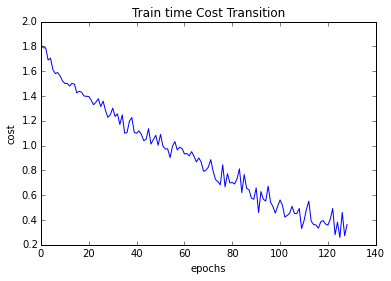

In [47]:
plt.plot(cost)
plt.ylabel('cost')
plt.xlabel('epochs')
plt.title('Train time Cost Transition')
plt.show()
plt.savefig('cost.jpg')

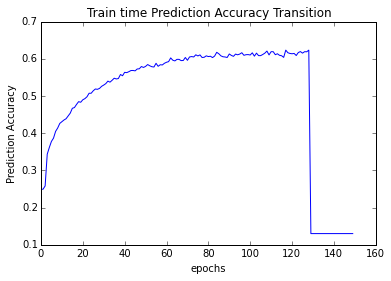

In [49]:
plt.plot(errors)
plt.ylabel('Prediction Accuracy')
plt.xlabel('epochs')
plt.title('Train time Prediction Accuracy Transition')
plt.show()
plt.savefig('prediction_accuracy.jpg')

In [52]:
A = Params[0].get_value()

In [67]:
A = A.reshape(64,1*7*7)

In [55]:
image = T.flatten(Params[0], outdim=2)
print image.shape

Shape.0


In [68]:
print A.shape

(64, 49)


In [56]:
from utils import tile_raster_images

In [77]:
filters = tile_raster_images(A ,(7,7) , (7,7) ,(3,3) )

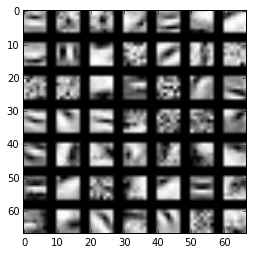

In [78]:
plt.imshow(filters,cmap = cm.Greys_r)